In [1]:
import cv2
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
face_cascade = cv2.CascadeClassifier("/content/drive/MyDrive/CO3519Assignment1/haarcascade_frontalface_default.xml")

def load_and_detect_faces(folder_path):
  images = []
  labels = []
  for label in os.listdir(folder_path):
    label_path = os.path.join(folder_path, label)
    if os.path.isdir(label_path):
      for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
          faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
          for(x, y, w, h) in faces:
            face_region = img[y:y+h, x:x+w]
            images.append(face_region)
            labels.append(label)
  return images, labels

train_folder_path = "/content/drive/MyDrive/CO3519Assignment1/CK_dataset/train"
test_folder_path = "/content/drive/MyDrive/CO3519Assignment1/CK_dataset/test"

X_train, y_train = load_and_detect_faces(train_folder_path)
X_test, y_test = load_and_detect_faces(test_folder_path)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def preprocess_images(images):
  preprocessed_images = []
  for img in images:
    img = cv2.equalizeHist(img)
    preprocessed_images.append(img)
  return preprocessed_images

radius = 1
n_points = 8 * radius

def extract_lbp_features(images):
  lbp_features = []
  for img in images:
    img = cv2.resize(img, (64, 64))
    lbp = local_binary_pattern(img, n_points, radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    lbp_features.append(hist)
  return np.array(lbp_features)

X_train_features = extract_lbp_features(X_train)
X_test_features = extract_lbp_features(X_test)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=7, gamma='scale'))

svm_classifier.fit(X_train_features, y_train)
y_pred = svm_classifier.predict(X_test_features)

svm_classifier.fit(X_train_features, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=7))])

In [6]:
y_pred = svm_classifier.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(y_test, y_pred)
print(len(y_test))
print(conf_matrix)


Accuracy: 39.16%
143
[[ 5  0  7  5  1  0]
 [ 1  0  0  4  2  0]
 [ 2  0 13  7  0  8]
 [ 3  0  3 18  1 11]
 [ 1  0  4  4  5  3]
 [ 2  0  6 11  1 15]]


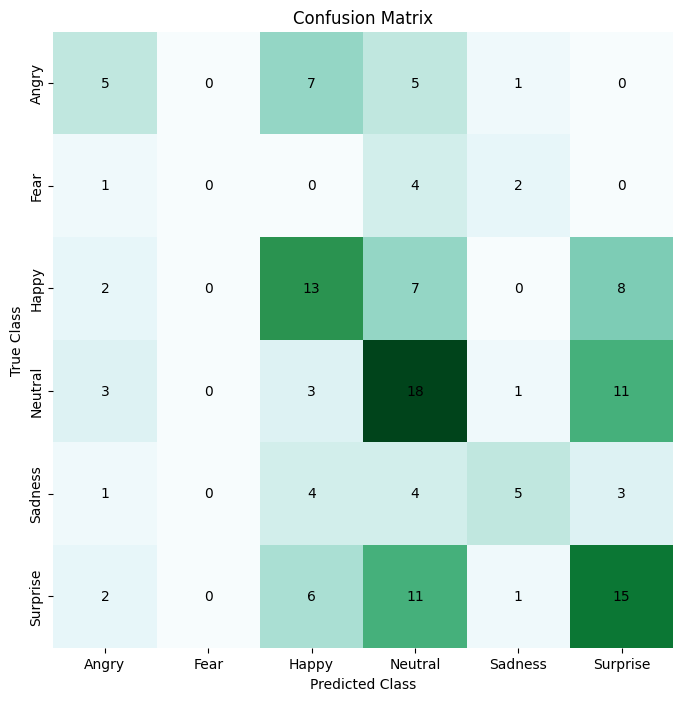

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

class_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn",
                 xticklabels=class_names, yticklabels=class_names, cbar=False)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        ax.text(j + 0.5, i + 0.5, f'{count}',
                ha="center", va="center", color="black", fontsize=10)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

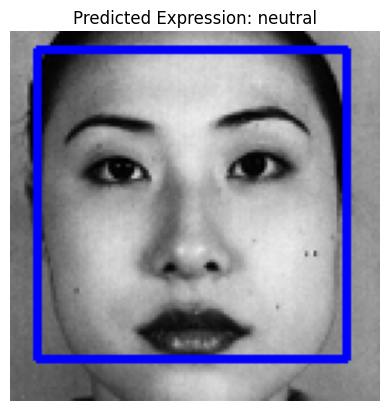

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

radius = 1
n_points = 8 * radius

face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/CO3519Assignment1/haarcascade_frontalface_default.xml')

def preprocess_and_extract_features(face_img):
    face_img = cv2.resize(face_img, (64, 64))

    lbp = local_binary_pattern(face_img, n_points, radius, method="uniform")

    (hist, _) = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, n_points + 3),
        range=(0, n_points + 2)
    )

    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)

    return hist.reshape(1, -1)

def predict_emotion(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or could not be loaded.")

    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(
        grey_img,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    if len(faces) == 0:
        print("No faces detected in the image.")
        return

    for (x, y, w, h) in faces:
        face_region = grey_img[y:y+h, x:x+w]

        features = preprocess_and_extract_features(face_region)

        predicted_expression = model.predict(features)[0]

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

        cv2.putText(
            img,
            predicted_expression,
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.3,
            (255, 0, 0),
            2
        )

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(f"Predicted Expression: {predicted_expression}")
    plt.axis('off')
    plt.show()


image_path = "/content/drive/MyDrive/CO3519Assignment1/testimages/24.tiff"
predict_emotion(image_path, svm_classifier)
